# Graph Neural Networks 실습 (Basic)

Standford CS224w(Fall 2019)에서 실습을 참고하였습니다.

최근 열린 강좌(Winter 2021)에서의 실습은 CS에서 다루는 구현적 내용이 많아서, 필요하신 분은 참고하시면 될 것 같습니다.[2][3]<br>
(CS 전공자 분들은 해당 강좌 Colab3 과제를 해보시는 것도 좋을 것 같습니다... 보다 최신 라이브러리를 활용해서 더 효율적인 그래프 처리를 진행합니다.)<br>
이 추가적인 모델 구현은 다음 세션에서 Pytorch Modeling을 구체적으로 실습하면서 PinSAGE실습과 함께 구현해보겠습니다.

실습에서는 PyTorch의 사용법을 간단하게 살펴보고, PyG(Pytorch Geometric)을 이용해서 GNN 실습을 진행해보고, 텐서보드에서 그 진행상황을 기록하고, Unsupervised의 임베딩을 matplotlib으로 시각화 해보겠습니다.

참고) GNN 모델링 시에 PyTorch Geometric Documentation이 매우 자세한 편이라서 이를 참고하는 것이 베스트입니다[1]

# 0단계: PyTorch 준비 및 복습

파이토치와 그외 사이킷런을 이용한 평가 등을 진행하기 위해 관련 라이브러리를 임포트하겠습니다.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import sklearn.metrics as metrics

이전에 CNN 세션에서 파이토치를 사용하는 방법을 익혔지만 다시한번 복습을 진행하겠습니다.
여기서는 Dataloader의 사용에 집중하시면 됩니다.

In [2]:
BATCH_SIZE = 32

## transformations
transform = transforms.Compose([transforms.ToTensor()])

## download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
# 데이터로더를 활용하면 사이즈별로 나눠주고 iterator 형식으로 저장하며, 뒤에서 보겠지만, (data, label) 와 같은 형식으로 건네줍니다.
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

|          | 0/? [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


|          | 0/? [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


|          | 0/? [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


|          | 0/? [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/Users/jaeyong/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
# MNIST의 6만개 데이터셋과 일치합니다
print(len(trainset))
# 28x28을 출력하고 싶다면 아래를 실행해보시면 됩니다.
# print(trainset[10])

60000


파이토치의 모델은 `nn.Module`을 슈퍼클래스로 가집니다.<br>
그외 아래에서 보이는 레이어들에 대해서는 이전 CNN 세션에서 다뤘기 때문에 패스하겠습니다.<br>
파이토치 모델에서 중요한 점은 `forward` 메소드를 반드시 구현해줘야한다는 것입니다. 이를 통해 parameter 업데이트와 미분이 가능하기 때문입니다. 복잡한 것이 아니라 단계적으로 layer에 값을 통과시켜주도록 메소드를 구현해주면 됩니다.

In [4]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # 28x28x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(26 * 26 * 32, 128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)
        x = F.relu(x)

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)
        #x = x.view(32, -1)

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

아래에서는 간단하게 파이토치의 `device` 개념에 대해서 살펴보도록 하겠습니다.<br>
Nvidia cuda가 제대로 설정이 되어있다면, `torch.cuda.is_available()`에서 True가 나오고 아니라면 False가 나오게 됩니다.<br>
cuda 코어를 활용하면 병렬 연산을 빠르게 수행할 수 있기 때문에 더 빠른 계산을 진행할 수 있습니다.<br>
(아마 이번 실습 수준에서는 gpu가 필요없겠지만, 실습 수준일 조금만 벗어나도 반드시 필요합니다. 아마 여러분이 진행하시는 모델링 프로젝트에서도 반드시 필요할 것이라고 생각됩니다. 그러한 경우에는 구글 코랩을 활용하시거나 개인 gpu를 활용해서 진행하시길 바랍니다.)

In [5]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
    
print(device)

cpu


`.to()` 메소드를 이용하면 객체를 gpu로 송신할 수 있고 그 이후에 cuda를 이용해서 연산이 가능합니다.<br>
연산을 진행할 때 cuda 위의 객체(in graphic memory)와 cpu 위의 객체(in memory)를 같이 연산할 경우 오류가 나기 때문에 유의하셔야합니다.

In [6]:
import numpy as np
a = np.array([[1,2],[3,4]])
b = np.ones((2,2))

ta = torch.tensor(a, dtype=float).to(device)
tb = torch.ones(2,2, dtype=float).to(device)

print(ta)
print(ta @ tb) # matmul 함수와 동일합니다.

tensor([[1., 2.],
        [3., 4.]], dtype=torch.float64)
tensor([[3., 3.],
        [7., 7.]], dtype=torch.float64)


이전에 공부했듯이, 모델을 설정하고 해당 모델을 gpu 상에 올려줍니다. <br>
또한 `criterion(loss)`함수를 설정해주고, GD를 위한 `optimizer`를 설정해줍니다.<br>
모델과 `criterion`, `optimizer`간의 상호작용은 뒤에서 설명하겠습니다.

In [7]:
learning_rate = 0.001
num_epochs = 1 # 실습이니 1 에폭만 돌립니다... 한 5에폭 돌리면 98-99퍼 accuracy 나옵니다

if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Now let's write our training loop. For each minibatch (accessed by enumerating through our data loader `trainloader`), we run our data through `model` in a forward pass, then compute the loss with `criterion`. We call `optimizer.zero_grad()` to zero out the gradients from the previous round of training, followed by `loss.backward()` to backpropagate the new round of gradients and finally `optimizer.step()` to adjust the model parameters based on these gradients.

In [8]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    ## training step
    # 앞에서 설명한 바와 마찬가지로 (data, label) 형태로 배치사이즈에 맞게 반환해줍니다.
    for i, (images, labels) in enumerate(trainloader):
        
        # in memory의 데이터를 gpu로 올려야 연산이 가능합니다.
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images) # 모델에 데이터를 통과시켜서 계산합니다
        loss = criterion(logits, labels) # 계산한 logit(CELoss 입니다...)을 loss함수에 넣어서 계산합니다.
        # 이부분에서 왜 loss를 이용했는데 optimizer.step()을 하면 업데이트 되는지 궁금해 하시는 분들이 많습니다.
        # 파이토치 코드를 보고 모델을 실제로 디버깅 해보시면, (디버깅 모드에서 model을 print해서 보시면 됩니다.)
        # loss는 파이토치 모델 내의 gradient 변수에 값을 저장합니다.
        # 그런데, optimizer는 model.parameters()를 통해서 모델과 연결되어있습니다.
        # 따라서 gradient update와 parameter update가 가능합니다.
        # (CS224w 강의에서 애매하게 답변이 나왔는데, 정확한 분석은 위와 같습니다.)
        optimizer.zero_grad() # 중요한 부분입니다: gradient 초기화를 해주지 않으면 이전 gradient와 accum 합니다. (순서가 중요)
        loss.backward() # 계산한 loss 함수를 이용해서 미분값을 계산합니다

        ## update model params
        optimizer.step() # 계산한 미분값을 이용해서 파라미터를 업데이트 합니다.

        train_running_loss += loss.detach().item()
        train_acc += (torch.argmax(logits, 1).flatten() == labels).type(torch.float).mean().item()
    
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))

Epoch: 0 | Loss: 1.6545 | Train Accuracy: 0.81


테스트를 위해서는 forward만 진행하면 됩니다.

In [9]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += (torch.argmax(outputs, 1).flatten() == labels).type(torch.float).mean().item()
    preds = torch.argmax(outputs, 1).flatten().cpu().numpy()
        
print('Test Accuracy: %.2f'%(test_acc/i))

Test Accuracy: 0.88


# 1단계: PyTorch Geometric 등 Setup

GNN 생성을 위한 PyG와 텐서보드X를 설치합니다.

In [10]:
# !pip install --verbose --no-cache-dir torch-scatter
# !pip install --verbose --no-cache-dir torch-sparse
# !pip install --verbose --no-cache-dir torch-cluster
# !pip install torch-geometric
# !pip install tensorboardX

필요한 라이브러리들을 임포트합니다.

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

# 실습용 그래프 데이터와 이를 사용하기 위한 데이터로더입니다.
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.transforms as T

# 텐서보드를 이용해서 시각화하기 위해 필요합니다.
from tensorboardX import SummaryWriter
# 임베딩의 시각화를 위해서 필요합니다.
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 2단계: GNN 모델 구성

GNN을 이용한 모델링에는 3가지가 있습니다. (1: 노드 분류, 2: 그래프 분류, 3: 링크 예측)<br>
우선, 노드분류와 그래프분류 모델링을 살펴보고, 뒤의 unsupervised에서 링크 예측을 진행해보겠습니다. <br>
`build_conv_model` 메소드에서는 어떤 노드분류와 그래프분류 모델링을 위한 각 모델을 골라서 레이어를 만들어줍니다. <br>
PyTorch Geometric에서는 이들 레이어에 대해서 바로 사용가능한 모듈을 제공해줍니다. Winter 2021 강좌에서는 이러한 레이어를 GraphSAGE와 GAT에 대해 구현해보는 것을 과제로 하고 있습니다. 사실 이 모델은 https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/conv/sage_conv.html#SAGEConv, https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/conv/gcn_conv.html#GCNConv 이곳을 살펴보면 되며, 앞의 세션에서 살펴본 내용을 그대로 torch 연산을 통해 진행하는 것 외에 특별한 점은 없습니다.<br>
아래에서는 3레이어의 conv 레이어를 이용하고 마지막으로 mean pooling과 fc 레이어 2개를 이용해서 진행하였습니다. <br>
분류를 목적으로 하기 때문에 loss의 경우에는 nll loss를 이용하였습니다.

In [12]:
class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, task='node'):
        super(GNNStack, self).__init__()
        self.task = task
        # 모듈리스트를 이용해서 레이어 추가
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        # 정규화 레이어 추가
        self.lns = nn.ModuleList()
        self.lns.append(nn.LayerNorm(hidden_dim))
        self.lns.append(nn.LayerNorm(hidden_dim))
        # 총 3개 레이어 이므로 2개 추가
        for l in range(2):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25), 
            nn.Linear(hidden_dim, output_dim))
        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Unknown task.')

        self.dropout = 0.25
        self.num_layers = 3

    def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        if self.task == 'node':
            # 원래는 GCNConv를 이용하지만, 아래에서 구현해본 결과를 살펴보기 위해서 해볼 것!
            return pyg_nn.GCNConv(input_dim, hidden_dim)
            #return CustomConv(input_dim, hidden_dim)
        else:
            return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                  nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.num_node_features == 0:
          x = torch.ones(data.num_nodes, 1)
        
        # 각 레이어 사이에는 ReLU와 오버피팅을 막기 위한 드롭아웃 추가
        # 그러나 마지막 레이어에는 추가하지 말아야함... 성능상 이유
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if not i == self.num_layers - 1:
                x = self.lns[i](x)
        
        # 그래프 분류의 경우에는 mean pool 진행해야함
        if self.task == 'graph':
            x = pyg_nn.global_mean_pool(x, batch)
        
        # 분류를 위한 fc 통과
        x = self.post_mp(x)

        return emb, F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

Here pyg_nn.GCNConv and pyg_nn.GINConv are instances of MessagePassing.<br>
(모든 PyG에서의 모델은 그래프의 기본인 MessagePassig을 슈퍼 클래스로 가진다.)<br>
They define a single layer of graph convolution, which can be decomposed into:<br>
(이들은 아래와 같은 이전 세션에서 다룬 기본 연산을 진행한다.)
* Message computation
* Aggregation
* Update
* Pooling

Here we give an example of how to subclass the pytorch geometric MessagePassing class to derive a new model (rather than using existing GCNConv and GINConv).<br>
(아래 예시에서는 실제로 이러한 사실을 감안해서 GCNConv를 구현해본다.)

아래와 같은 특성을 이용해서 실제로 GCNConv를 구현해보고, 이를 위의 모델과 만든 모델 간 각각 실행해서 효과가 동일한지 살펴볼 것!
We make use of `MessagePassing`'s key building blocks:
- `aggr='add'`: The aggregation method to use ("add", "mean" or "max").
- `propagate()`: The initial call to start propagating messages. Takes in the edge indices and any other data to pass along (e.g. to update node embeddings).
- `message()`: Constructs messages to node i. Takes any argument which was initially passed to propagate().
- `update()`: Updates node embeddings. Takes in the output of aggregation as first argument and any argument which was initially passed to propagate().

여기를 참고하면 큰 도움이 됩니다.<br>
https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html#implementing-the-gcn-layer

In [13]:
class CustomConv(pyg_nn.MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomConv, self).__init__(aggr='add')  # "Add" aggregation.
        self.lin = nn.Linear(in_channels, out_channels)
        
#         # 방법2를 해보기 위해서 추가함.
#         self.lin_self = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]
        
        # 방법 1 : self loop를 메소드로 추가
        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = pyg_utils.add_self_loops(edge_index, num_nodes=x.size(0))
        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)
        
#         # 방법 2: 수동으로 Identity Matrix 더해줌
#         # Step 1: Remove self-loops from the adjacency matrix. (add later)
#         edge_index, _ = pyg_utils.remove_self_loops(edge_index)
#         # Step 2: Linearly transform node feature matrix.
#         self_x = self.lin_self(x)
#         return self_x + self.propagate(edge_index, size=(x.size(0), x.size(0)), x=self.lin(x))

    def message(self, x_j, edge_index, size):
        # Compute messages
        # x_j has shape [E, out_channels]

        # Step 3: Compute normalization.
        # Step 4: Normalize node features.
        # Step 4-5: Start propagating messages.
        row, col = edge_index
        deg = pyg_utils.degree(row, size[0], dtype=x_j.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        return norm.view(-1, 1) * x_j

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]
        
        return aggr_out

In [14]:
class GNNCustomStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, task='node'):
        super(GNNCustomStack, self).__init__()
        self.task = task
        # 모듈리스트를 이용해서 레이어 추가
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        # 정규화 레이어 추가
        self.lns = nn.ModuleList()
        self.lns.append(nn.LayerNorm(hidden_dim))
        self.lns.append(nn.LayerNorm(hidden_dim))
        # 총 3개 레이어 이므로 2개 추가
        for l in range(2):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25), 
            nn.Linear(hidden_dim, output_dim))
        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Unknown task.')

        self.dropout = 0.25
        self.num_layers = 3

    def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        if self.task == 'node':
            # 원래는 GCNConv를 이용하지만, 아래에서 구현해본 결과를 살펴보기 위해서 해볼 것!
            #return pyg_nn.GCNConv(input_dim, hidden_dim)
            return CustomConv(input_dim, hidden_dim)
        else:
            return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                  nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.num_node_features == 0:
          x = torch.ones(data.num_nodes, 1)
        
        # 각 레이어 사이에는 ReLU와 오버피팅을 막기 위한 드롭아웃 추가
        # 그러나 마지막 레이어에는 추가하지 말아야함... 성능상 이유
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if not i == self.num_layers - 1:
                x = self.lns[i](x)
        
        # 그래프 분류의 경우에는 mean pool 진행해야함
        if self.task == 'graph':
            x = pyg_nn.global_mean_pool(x, batch)
        
        # 분류를 위한 fc 통과
        x = self.post_mp(x)

        return emb, F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

# 3단계: Training

CNN 모델링과 동일하게 training은 흐름이 이루어집니다. <br>
그런데 데이터 셋의 경우, 그래프 분류의 경우에는 len을 기준(80:20)으로 나누면 되지만, 노드 분류의 경우에는 그렇지 않기 때문에 `batch.train_mask`를 활용해서 진행하게 됩니다.

In [15]:
def train(dataset, task, writer):
    if task == 'graph':
        # 그래프 분류의 경우에는 단순하게 나누면 됨.
        data_size = len(dataset)
        loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=64, shuffle=True)
        test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=64, shuffle=True)
    else:
        # 노드 분류의 경우에는 batch.train_mask 활용할 것
        test_loader = loader = DataLoader(dataset, batch_size=64, shuffle=True)

    # build model
    # GNNStack 대신 직접 구현한 GCN 모델 활용해볼 것
    # GCNCustomStack(이 경우에 결과가 비슷한가??)
    model = GNNStack(max(dataset.num_node_features, 1), 32, dataset.num_classes, task=task)
    opt = optim.Adam(model.parameters(), lr=0.01)
    
    # train
    for epoch in range(200):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            embedding, pred = model(batch)
            label = batch.y
            if task == 'node':
                pred = pred[batch.train_mask]
                label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        writer.add_scalar("loss", total_loss, epoch)

        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            print("Epoch {}. Loss: {:.4f}. Test accuracy: {:.4f}".format(
                epoch, total_loss, test_acc))
            writer.add_scalar("test accuracy", test_acc, epoch)

    return model

Test time, for the CiteSeer/Cora node classification task, there is only 1 graph. So we use masking to determine validation and test set.

For graph classification tasks, a subset of graphs is considered validation / test graph.

In [16]:
def test(loader, model, is_validation=False):
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            emb, pred = model(data)
            pred = pred.argmax(dim=1)
            label = data.y

        if model.task == 'node':
            mask = data.val_mask if is_validation else data.test_mask
            # node classification: only evaluate on nodes in test set
            pred = pred[mask]
            label = data.y[mask]
            
        correct += pred.eq(label).sum().item()
    
    if model.task == 'graph':
        total = len(loader.dataset) 
    else:
        total = 0
        for data in loader.dataset:
            total += torch.sum(data.test_mask).item()
    return correct / total

# 3단계: Training (실행 및 tensorboard 출력)

이제 훈련과 출력을 진행합니다. <br>
아래 명령어를 실행하면 `localhost:6006`에 텐서보드가 생성되고, 이를 통해서 log를 출력해볼 수 있습니다. <br>
`scalars` 탭에서 리프레시를 하면 로그가 출력됩니다.<br>

In [17]:
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format("./log")
)

텐서보드 좌측에서는 여러개 로그가 기록되었을 경우 골라서 살펴볼 수 있습니다.

이제 대표적인 그래프 데이터셋은 영화(IMDB-BINARY) 데이터셋을 분류해보겠습니다.

In [18]:
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
dataset = dataset.shuffle()
task = 'graph'

model = train(dataset, task, writer)

Extracting /tmp/ENZYMES/ENZYMES/ENZYMES.zip
Processing...
Done!
Epoch 0. Loss: 1.8250. Test accuracy: 0.1333
Epoch 10. Loss: 1.7590. Test accuracy: 0.2250
Epoch 20. Loss: 1.7167. Test accuracy: 0.2250
Epoch 30. Loss: 1.6892. Test accuracy: 0.2333
Epoch 40. Loss: 1.6934. Test accuracy: 0.2417
Epoch 50. Loss: 1.6672. Test accuracy: 0.2000
Epoch 60. Loss: 1.6507. Test accuracy: 0.2500
Epoch 70. Loss: 1.6553. Test accuracy: 0.2417
Epoch 80. Loss: 1.6083. Test accuracy: 0.2500
Epoch 90. Loss: 1.6187. Test accuracy: 0.2250
Epoch 100. Loss: 1.6102. Test accuracy: 0.2583
Epoch 110. Loss: 1.6139. Test accuracy: 0.2333
Epoch 120. Loss: 1.6022. Test accuracy: 0.2167
Epoch 130. Loss: 1.5678. Test accuracy: 0.2417
Epoch 140. Loss: 1.5948. Test accuracy: 0.2500
Epoch 150. Loss: 1.5829. Test accuracy: 0.2500
Epoch 160. Loss: 1.6052. Test accuracy: 0.2917
Epoch 170. Loss: 1.5729. Test accuracy: 0.2250
Epoch 180. Loss: 1.5792. Test accuracy: 0.2500
Epoch 190. Loss: 1.6568. Test accuracy: 0.2167


Citeseer citation network에 대해서는 노드 분류를 진행해보겠습니다.

In [19]:
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = Planetoid(root='/tmp/cora', name='cora')
task = 'node'

model = train(dataset, task, writer)

Processing...
Done!
Epoch 0. Loss: 1.9804. Test accuracy: 0.2110
Epoch 10. Loss: 0.4575. Test accuracy: 0.7640
Epoch 20. Loss: 0.0717. Test accuracy: 0.7760
Epoch 30. Loss: 0.0241. Test accuracy: 0.7270
Epoch 40. Loss: 0.0030. Test accuracy: 0.7550
Epoch 50. Loss: 0.0643. Test accuracy: 0.7630
Epoch 60. Loss: 0.0114. Test accuracy: 0.7400
Epoch 70. Loss: 0.0785. Test accuracy: 0.7310
Epoch 80. Loss: 0.0028. Test accuracy: 0.7650
Epoch 90. Loss: 0.0742. Test accuracy: 0.7550
Epoch 100. Loss: 0.0026. Test accuracy: 0.7440
Epoch 110. Loss: 0.0025. Test accuracy: 0.7590
Epoch 120. Loss: 0.0491. Test accuracy: 0.7470
Epoch 130. Loss: 0.0030. Test accuracy: 0.7400
Epoch 140. Loss: 0.0022. Test accuracy: 0.7440
Epoch 150. Loss: 0.0151. Test accuracy: 0.7360
Epoch 160. Loss: 0.0008. Test accuracy: 0.7730
Epoch 170. Loss: 0.0002. Test accuracy: 0.7220
Epoch 180. Loss: 0.0050. Test accuracy: 0.7260
Epoch 190. Loss: 0.0037. Test accuracy: 0.7480


# 4단계: 결과 시각화 (노드 임베딩 2차원화)

One great quality about graph neural networks is that, like other deep methods, their hidden layers provide low-dimensional representations of our data. In the case of node classification, we get a low-dimensional representation for each node in our graph. Let's visualize the output of the last convolutional layer in our node classification GNN via TSNE, a method for plotting high-dimensional data. Nodes are colored according to their labels. We see that nodes with similar labels tend to be near each other in the embedding space, a good indication that our model has learned a useful representation.<br>
분류한 결과값(모델을 통과시킨 값)이 군집이 잘 형성되었다는 것은 임베딩이 서로 가까웠다는 것을 의미하기 때문에 학습이 비교적 잘 이루어졌음을 의미합니다.

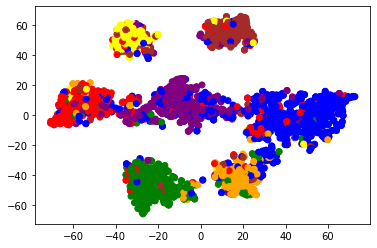

In [20]:
color_list = ["red", "orange", "green", "blue", "purple", "brown", "yellow"]

loader = DataLoader(dataset, batch_size=64, shuffle=True)
embs = []
colors = []
for batch in loader:
    # 모델을 통과시켜서 나온 결과를 볼 것
    emb, pred = model(batch)
    embs.append(emb)
    colors += [color_list[y] for y in batch.y]
embs = torch.cat(embs, dim=0)

xs, ys = zip(*TSNE().fit_transform(embs.detach().numpy()))
plt.scatter(xs, ys, color=colors)

# 추가: Learning unsupervised embeddings with graph autoencoders (GAE 활용)

Finally, GNNs fit nicely in the framework of other neural approaches, and can be used as part of autoencoder techniques, pretraining and multitask learning methods, etc. Here we explore the idea of neural network representations further by building a graph autoencoder which learns these representations in a completely unsupervised way. In contrast to the previous example, we do not make use of the given node labels when training this representation. Instead, we encode the nodes in our network in a low-dimensional space in such a way that the embeddings can be decoded into a reconstruction of the original network. We use graph convolutional layers in the encoder.

You can again use TensorBoardX here to visualize the training progress.

GCN 레이어를 이용해서 통과시킨 뒤에 Adj Matrix를 점곱으로 추정하는 것이 가능합니다.<br>
`Variational Graph Auto-Encoders` 논문 참고... (매우 쉬운 논문입니다.)[4] <br>
이를 통해서 unsupservised learning이 가능합니다.

In [21]:
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = pyg_nn.GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = pyg_nn.GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

def train(epoch):
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    loss.backward()
    optimizer.step()
    
    writer.add_scalar("loss", loss.item(), epoch)

def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = Planetoid("/tmp/citeseer", "Citeseer", split='random', transform=T.NormalizeFeatures())
data = dataset[0]

channels = 16
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('CUDA availability:', torch.cuda.is_available())

# encoder: written by us; decoder: default (inner product)
# 점곱을 계산하는 GAE를 이용해서 앞에서 계산한 GCN을 통과시킨 것과 비교해봅니다.
model = pyg_nn.GAE(Encoder(dataset.num_features, channels)).to(dev)
labels = data.y
data.train_mask = data.val_mask = data.test_mask = data.y = None
data = pyg_utils.train_test_split_edges(data)
# 새로운 util인 https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/utils/train_test_split_edges.html
# train_test_split_edges 이용...
# 원래 (현재 작동하지 않는 코드)
# data = model.split_edges(data)
x, train_pos_edge_index = data.x.to(dev), data.train_pos_edge_index.to(dev)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1, 201):
    train(epoch)
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    writer.add_scalar("AUC", auc, epoch)
    writer.add_scalar("AP", ap, epoch)
    if epoch % 10 == 0:
        print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

Processing...
Done!
CUDA availability: False
Epoch: 010, AUC: 0.6689, AP: 0.7323
Epoch: 020, AUC: 0.7677, AP: 0.7804
Epoch: 030, AUC: 0.7876, AP: 0.8002
Epoch: 040, AUC: 0.8411, AP: 0.8478
Epoch: 050, AUC: 0.8553, AP: 0.8606
Epoch: 060, AUC: 0.8499, AP: 0.8550
Epoch: 070, AUC: 0.8564, AP: 0.8616
Epoch: 080, AUC: 0.8602, AP: 0.8674
Epoch: 090, AUC: 0.8704, AP: 0.8766
Epoch: 100, AUC: 0.8717, AP: 0.8768
Epoch: 110, AUC: 0.8688, AP: 0.8748
Epoch: 120, AUC: 0.8672, AP: 0.8734
Epoch: 130, AUC: 0.8648, AP: 0.8722
Epoch: 140, AUC: 0.8637, AP: 0.8725
Epoch: 150, AUC: 0.8672, AP: 0.8766
Epoch: 160, AUC: 0.8697, AP: 0.8782
Epoch: 170, AUC: 0.8704, AP: 0.8787
Epoch: 180, AUC: 0.8711, AP: 0.8792
Epoch: 190, AUC: 0.8724, AP: 0.8801
Epoch: 200, AUC: 0.8760, AP: 0.8837


보면 논문과 유사한 수준의 결과가 나온 것을 알 수 있습니다(경우에 따라 4-5프로 가량 낮게 나오기도 하는데 더 돌려주면 나옵니다)<br>
Finally, we plot our embeddings (the output of the encoder) with TSNE. We color each node embedding according to its label -- but note that we did not use any label information when training our encoder. Nodes with the same label are nevetheless close together in the embedding space. The model has learned the community structure without supervision!

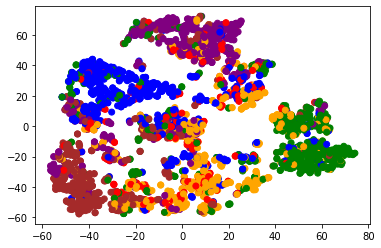

In [22]:
model.eval()
z = model.encode(x, train_pos_edge_index)
colors = [color_list[y] for y in labels]

xs, ys = zip(*TSNE().fit_transform(z.cpu().detach().numpy()))
plt.scatter(xs, ys, color=colors)
plt.show()

# Reference
1. https://pytorch-geometric.readthedocs.io/en/latest/index.html
2. http://snap.stanford.edu/class/cs224w-2019/
3. http://web.stanford.edu/class/cs224w/
4. https://arxiv.org/abs/1611.07308